## Deconvolution 

This notebook presents custom deconvolution implementation using **cosine basis set** for representing neural signal and **ridge regression** for solving linear equations. In constrast, SPM implementation of deconvolution `spm_peb_ppi.m` uses Parametric empirical Bayes method (without free parameters) for solving linear equations. Ridge regression approach is validated using synthetically generated neural and BOLD data with varying amount of noise. Analysis is focused on influence of regularization parameter $\alpha$ on reconstructed neural activity. 

---
**Last update**: 30.04.2020

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sys
import os

from nistats import hemodynamic_models
from sklearn.linear_model import Ridge
from sklearn.preprocessing import normalize

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
from dn_utils.glm_utils import convolve      

%matplotlib inline

<ipython-input-1-0ed51cfa1162>:7: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats import hemodynamic_models


In [2]:
def dct_basis(n, k):
    '''Creates basis functions for Discrete Cosine Transform (DCT).
    
    Args:
        n (int): Number of signal timepoints.
        k (int): Number of basis functions.
        
    Returns:
        Discrete cosine basis set in a matrix form. Shape of the matrix is n x k.
    '''
    X = np.zeros((n, k))
    for i in range(k):
        X[:, i] = np.sqrt(2 / n) * np.cos(np.pi * np.arange(n) * i / n)
    return X

def deconvolve(signal, alpha, X, HX):
    '''Deconvolve signal using ridge regression and cosine basis set.
    
    Uses ridge regression for solving set of correlated linear equations. Ridge regression allows 
    solving matrix equation y=Xb+e introducing regularization parameter. X corresponds to chosen
    basis set (here cosine set convolved with HRF), b is a vector of unknown weights for basis 
    functions and y is modeled signal. Fitted b weights are used to recreate neural signal as linear
    combinations of unconvolved cosines.
    
    Args:
        signal (iterable):
            BOLD signal.
        alpha (float):
            Regularization parameter (lower-bounded by zero).
        X (2-D array):
            Basis functions in neural space (not convolved).
        HX (2-D array):
            Basis functions in BOLD space (convolved with HRF).
        
    Returns:
        Deconvolved BOLD signal in neural space.
    '''
    lin = Ridge(
        alpha=alpha,
        solver='lsqr',
        fit_intercept=False,
        normalize=False,
        max_iter=1000
    )
    lin.fit(HX, signal)
    return np.matmul(X, lin.coef_) 

def noisify(signal, fract=0.1):
    '''Add Gaussian noise to the signal.
    
    Adds zero mean noise with standard deviation of requested fraction of standard deviation of 
    input signal. 
    
    Args:
        signal (iterable):
            Signal of interest.
        fract (float):
            Standard devitation of noise expressed as fraction of standard deviation of input 
            signal.

    Returns:
        Signal with added noise.
    '''
    return signal + np.random.randn(len(signal)) * np.std(signal) * fract

def normalize_1d(signal):  
    '''Normalize vector by scaling it to unit norm (using L2 norm).'''
    return normalize(signal[:, np.newaxis], axis=0).ravel()

In [3]:
# Settings
n_volumes = 730
t_r = 2

### Hemodynamic response function

Two popular shapes of hemodynamic response functions are called Glover and double-gamma HRF implemented in SPM. Hemodynamic function peaks at around 5-7 seconds after onset of neural event, and gradually decreseases to reach slight undershoot after around 15 seconds after onset of neural event. After around 25 seconds after onset of neural event, hemodynamic level goes back to inital baseline. Module `hemodynamic_models` from nistats allows to recreate downsampled canonical HRFs for different models. 

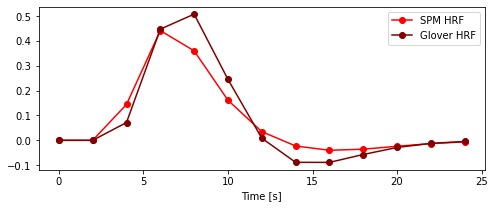

In [4]:
hrf_duration = 26
hrf_spm = hemodynamic_models.spm_hrf(t_r, oversampling=1, time_length=hrf_duration, onset=0.0)
hrf_glover = hemodynamic_models.glover_hrf(t_r, oversampling=1, time_length=hrf_duration, onset=0.0)

time = np.arange(0, hrf_duration, t_r) 

fig, ax = plt.subplots(figsize=(8, 3), facecolor='w')

ax.plot(time, hrf_spm, 'o-', color='r', label='SPM HRF')
ax.plot(time, hrf_glover, 'o-', color='maroon', label='Glover HRF')
ax.set_xlabel('Time [s]')
ax.legend()
plt.show()

### Matrix formulation of convolution

Hemodynamic response to neuronal activity is modeled by convolution of neural activity with a hemodynamic impulse response function:
$$y_t=\sum_{\tau}h_{\tau}x_{t - \tau},$$ 
where $y_t$ is measured BOLD at time $t$, $h_t$ is assumed hemodynamic response at time $t$ and $x_t$ is true neuronal signal at time $t$. Convolution can also be expressed in matrix form:
$$y=Hx,$$
where $y$ and $x$ are BOLD and neural signal vectors and $H$ is hemodynamic response function in Toeplitz matrix form (see Figure below). 

/home/kmb/miniconda3/envs/decidenet/lib/python3.8/site-packages/nistats/hemodynamic_models.py:63: RuntimeWarning: invalid value encountered in true_divide
  hrf /= hrf.sum()


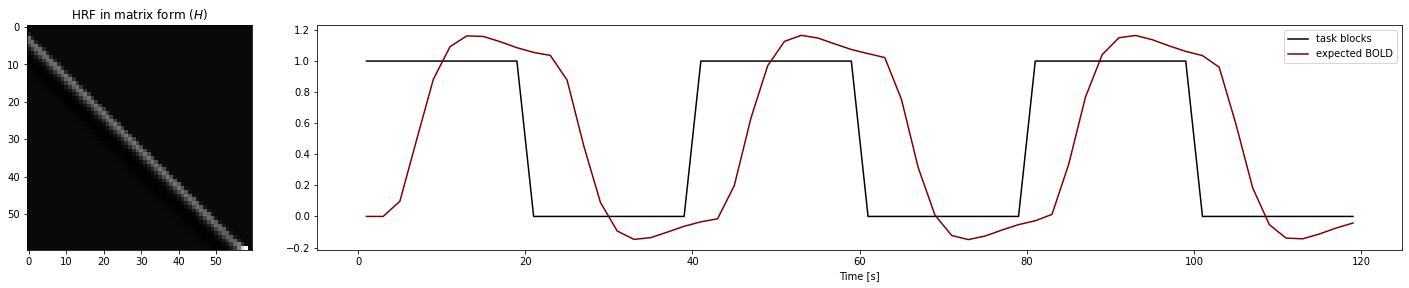

In [5]:
hrf_matrix = np.zeros((60, 60))

for vol in range(60):
    hrf_matrix[:, vol] = hemodynamic_models.spm_hrf(t_r, oversampling=1, 
                                                    time_length=t_r*60,
                                                    onset=float(vol*t_r))    
hrf_matrix = np.nan_to_num(hrf_matrix)
events = np.repeat([1, 0, 1, 0, 1, 0], 10)    
    
fig = plt.figure(figsize=(20, 4))
gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1, 4])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.imshow(hrf_matrix, cmap='gray')
ax1.set_title(r'HRF in matrix form ($H$)')
ax2.plot(np.arange(1, 60*t_r, t_r), events, 'k', label='task blocks')
ax2.plot(np.arange(1, 60*t_r, t_r), np.matmul(hrf_matrix, events), color='maroon', label='expected BOLD')
ax2.set_xlabel('Time [s]')
ax2.legend()

plt.tight_layout()

### Basis set

Let's assume that we measured BOLD signal, which is neuronal signal convolved with HRF with some extra noise. We want to deduce underlying neuronal activity. First, we can expand unknown neuronal activity in terms of a temporal basis set $X$. We can choose either a Fourier series or a set of cosine functions. We can write our neuronal signal as linear comibnations of cosine functions and unknown $\beta$ coefficients. Our goal will be to find these cooeficients.
$$x=X\beta$$
Since $y=Hx$, we can take noise $\epsilon$ into account and write a linear model:
$$y=HX\beta + \epsilon$$
Maximum likelihood estimate for $\beta$ can be found using the Gauss-Markov theorem:
$$\hat{\beta}_{ML}=(X^TH^THX)^{-1}X^{T}H^{T}y$$
The problem with MLE approach is that estimates based on a full-rank basis set are highly variable (not effieicient). This is particularly true for the $\beta$ coefficients controlling high frequencies, since HRF attenuates them (smooths out the response). Therefore, some form of regularization should be introduced to supress this confounding effect. 

Here, discrete cosine basis set $X$ is created for number of timepoints equal to number of acquired volumes. Number of basis function also equals number of timepoints (full rank basis set). All basis functions are then convolved with HRF since we have to estimate $\beta$ weights for $HX$ matrix.

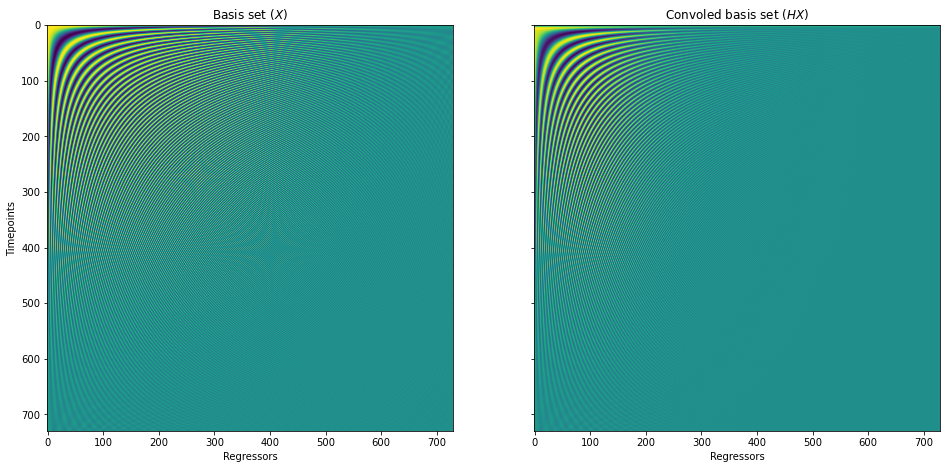

In [6]:
# Create cosine basis set
X = dct_basis(n_volumes, n_volumes)

# Convolve basis set with HRF
HX = np.zeros(X.shape)
for i, xi in enumerate(X):
    HX[:, i] = convolve(xi)

fig, ax = plt.subplots(figsize=(16, 8), ncols=2, sharey=True)

ax[0].imshow(X)
ax[0].set_title(r'Basis set ($X$)')
ax[0].set_xlabel('Regressors')
ax[0].set_ylabel('Timepoints')

ax[1].imshow(HX)
ax[1].set_title(r'Convoled basis set ($HX$)')
ax[1].set_xlabel('Regressors')

plt.show()

### Create simulated response

Here, simulated neural response to sparsely placed events (5% volumes) is calculated. Neural response is then convolved with a standard double-gamma SPM hrf and plotted for different levels of Gaussian noise. Gaussian noise have standard deviation that is either 50 or 100% of BOLD signal standard deviation.


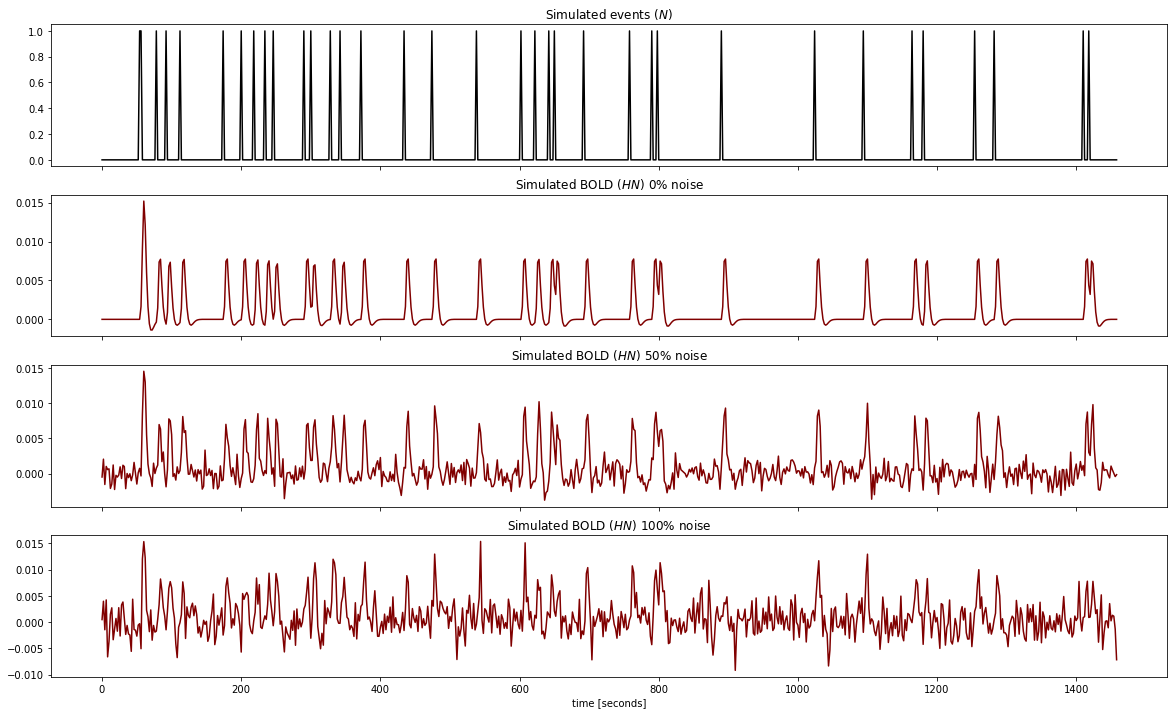

In [7]:
np.random.seed(5)

# Create neural response
events = (np.random.random(n_volumes) > .95) * 1

time = np.arange(0, n_volumes * t_r, t_r)
bold = {noise: noisify(convolve(events), noise) for noise in [0, 0.25, 0.5, 0.75, 1]}

fig, ax = plt.subplots(figsize=(20, 12), nrows=4, sharex=True)

ax[0].plot(time, events, 'k')
ax[0].set_title('Simulated events ($N$)')

ax[1].plot(time, bold[0], 'maroon')
ax[1].set_title('Simulated BOLD ($HN$) 0% noise')

ax[2].plot(time, bold[.5], 'maroon')
ax[2].set_title('Simulated BOLD ($HN$) 50% noise')

ax[3].plot(time, bold[1], 'maroon')
ax[3].set_title('Simulated BOLD ($HN$) 100% noise')

ax[-1].set_xlabel('time [seconds]')
plt.show()

### Solving linear model

Linear model is solved using ridge regression. Ridge regression modifies $\beta$ estimate introducing regularization parameter $\alpha$ which effectively penalize higher coefficients preventing model overfitting to noise:
$$\hat{\beta}_{ridge}=(X^TH^THX+\alpha\mathbb{1})^{-1}X^{T}H^{T}y$$
The higher the value of $\alpha$ the more regularization is applied. For $\alpha=0$ ridge regression reduces to ordinary least-squares (OLS) method $\hat{\beta}_{ridge}=\hat{\beta}_{ML}$.

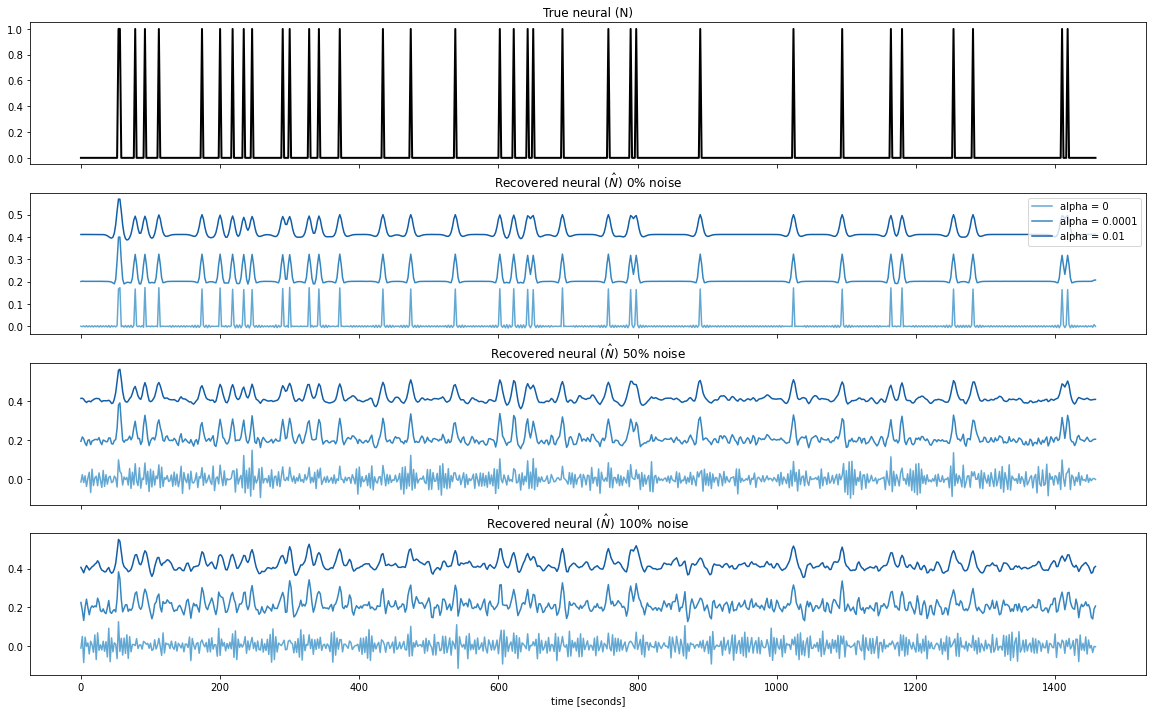

In [8]:
time = np.arange(0, n_volumes * t_r, t_r)

fig, ax = plt.subplots(figsize=(20, 12), nrows=4, sharex=True)
cmap = matplotlib.cm.get_cmap('Blues')

ax[0].plot(time, events, lineWidth=2, color='k')
ax[0].set_title('True neural (N)')

for i, alpha in enumerate([0, 0.0001, 0.01]):
    neur = {noise: deconvolve(signal, alpha, X, HX) for noise, signal in bold.items()}

    ax[1].plot(time, normalize_1d(neur[0]) + i/5, color=cmap(0.75 + (i - 1.5) * .15), label=f"alpha = {alpha}")
    ax[1].set_title('Recovered neural ($\hat{N}}$) 0% noise')

    ax[2].plot(time, normalize_1d(neur[.5]) + i/5, color=cmap(0.75 + (i - 1.5) * .15))
    ax[2].set_title('Recovered neural ($\hat{N}}$) 50% noise')

    ax[3].plot(time, normalize_1d(neur[1]) + i/5, color=cmap(0.75 + (i - 1.5) * .15))
    ax[3].set_title('Recovered neural ($\hat{N}}$) 100% noise')

    ax[-1].set_xlabel('time [seconds]')

ax[1].legend()
plt.show()

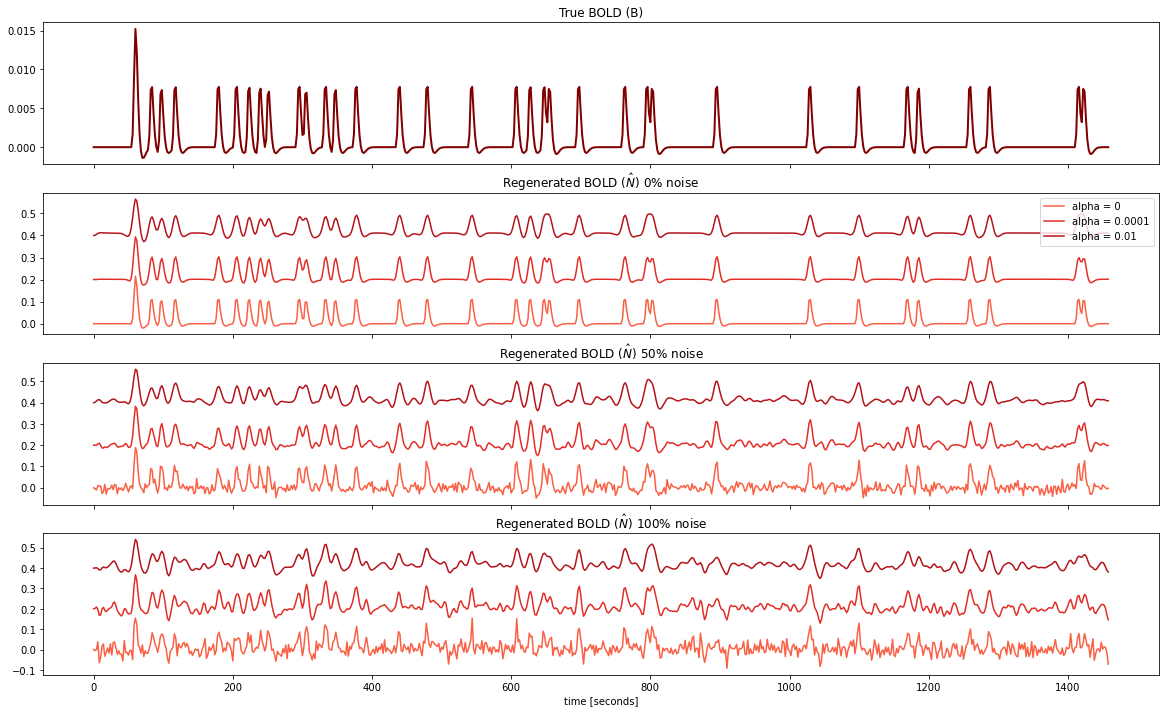

In [9]:
time = np.arange(0, n_volumes * t_r, t_r)

fig, ax = plt.subplots(figsize=(20, 12), nrows=4, sharex=True)
cmap = matplotlib.cm.get_cmap('Reds')

ax[0].plot(time, bold[0], lineWidth=2, color='maroon')
ax[0].set_title('True BOLD (B)')

for i, alpha in enumerate([0, 0.0001, 0.01]):

    regen = {noise: convolve(deconvolve(signal, alpha, X, HX)) for noise, signal in bold.items()}

    ax[1].plot(time, normalize_1d(regen[0]) + i/5, color=cmap(0.75 + (i - 1.5) * .15), label=f"alpha = {alpha}")
    ax[1].set_title('Regenerated BOLD ($\hat{N}}$) 0% noise')

    ax[2].plot(time, normalize_1d(regen[.5]) + i/5, color=cmap(0.75 + (i - 1.5) * .15))
    ax[2].set_title('Regenerated BOLD ($\hat{N}}$) 50% noise')

    ax[3].plot(time, normalize_1d(regen[1]) + i/5, color=cmap(0.75 + (i - 1.5) * .15))
    ax[3].set_title('Regenerated BOLD ($\hat{N}}$) 100% noise')

    ax[-1].set_xlabel('time [seconds]')

ax[1].legend()
plt.show()

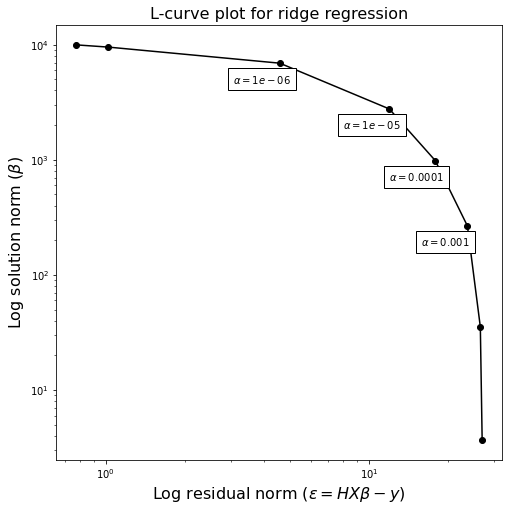

In [10]:
# Load data
data = np.load(os.path.join(
    path_root, 
    'data/main_fmri_study/derivatives/ppi/timeseries', 
    'timeseries_pipeline-24HMPCSFWM_atlas-customROI_bold.npy'))

bold_real = data[0, 0, :, 0]

# L-Curve method
alphas = np.logspace(-8, -1, 8)
n_params = len(alphas)

solution_norm = np.zeros(n_params) # norm for (b; beta weights) vector
residual_norm = np.zeros(n_params) # norm for (HX * b – y; residual) vector

for i, alpha in enumerate(alphas):
    lin = Ridge(
        alpha=alpha,
        solver='lsqr',
        fit_intercept=False,
        normalize=False,
        max_iter=1000
    )
    lin.fit(HX, bold_real)
    
    solution_norm[i] = np.linalg.norm(lin.coef_, 2)
    residual_norm[i] = np.linalg.norm(np.matmul(HX, lin.coef_) - bold_real, 2)

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))

ax.loglog(residual_norm, solution_norm, 'ko-')
ax.set_xlabel(r'Log residual norm ($\epsilon = HX\beta - y$)', fontSize=16)
ax.set_ylabel(r'Log solution norm ($\beta$)', fontSize=16)
ax.set_title('L-curve plot for ridge regression', fontSize=16)

for rn, sn, alpha in zip(residual_norm, solution_norm, alphas):
    if alpha < 10**(-2) and alpha > 10**(-7):
        ax.text(rn / 1.5, sn / 1.5, 
                fr'$\alpha = {alpha}$', 
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5})
plt.show()